In [1]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from sklearn.metrics import accuracy_score
from active_tester import ActiveTester
from active_tester.estimators.learned import Learned
from active_tester.query_strategy.noisy_label_uncertainty import LabelUncertainty
from active_tester.label_estimation.methods import oracle_multiple_labels

import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns
import pandas as pd

## Active Testing Using Text Data

This notebook contains an example of using the active testing package with an image dataset.  We use the MNIST Fashion dataset, which can be downloaded using the tensorflow package.

Note: running the cell below will download the dataset, if you do not already have it.

In [2]:
# Load Fashion Mnist dataset from Tensorflow and assign variables necessary for Active Testing
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X = test_images

Y_ground_truth = test_labels

The dataset will have noisy labels from 3 experts.  The labels are randomly generated and simulate different levels of labeling expertise.  The first expert gets the correct label 75% of the time, the second expert gets the correct label 50% of the time, and the third expert gets the correct label 25% of the time.

In [3]:
def create_noisy_labels(ground_truth, prob, num_classes, rows):
    '''
    Functions for creating noisy labels from a given fraction of correct labels
    Args:
    ground_truth : ground truth array
    prob: float of fraction of labels to get correct
    num_classes: number of possible labels
    rows: numer of rows
    
    Returns: numpy array of noisy labels for given expert 
    '''
    labels = []
    for i in range(len(ground_truth)):
        if np.random.rand() < prob:
            labels.append(ground_truth[i])
        else:
            labels.append(np.random.choice(np.delete(np.arange(num_classes),ground_truth[i])))
    labels = np.asarray(labels, dtype=int)
    labels = np.reshape(labels,(len(labels),1))
        
    return labels



Y_noisy = np.hstack(((create_noisy_labels(Y_ground_truth, 0.75, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.5, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.25, len(class_names), len(X)))))

We can see a few examples of the images, along with the true labels, and those predicted by the experts.

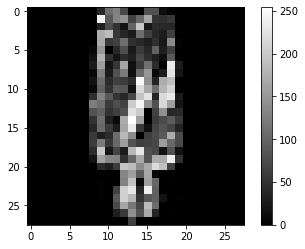

Ground Truth: Shirt
Expert 1: Ankle boot
Expert 2: Sneaker
Expert 3: Coat


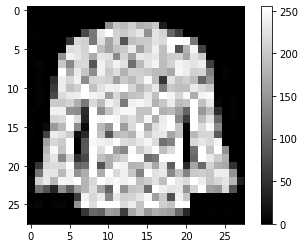

Ground Truth: Shirt
Expert 1: Shirt
Expert 2: Pullover
Expert 3: Trouser


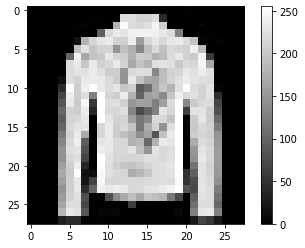

Ground Truth: Coat
Expert 1: Coat
Expert 2: Coat
Expert 3: Coat


In [4]:
# Plot example image given an index
def plot_example(index):
    plt.figure()
    plt.imshow(np.squeeze(X[index]), cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.show()
    print("Ground Truth: %s" % class_names[Y_ground_truth[index]])
    print("Expert 1: %s" % class_names[Y_noisy[index][0]])
    print("Expert 2: %s" % class_names[Y_noisy[index][1]])
    print("Expert 3: %s" % class_names[Y_noisy[index][2]])
    
for i in range(3):
    index = np.random.randint(0, len(Y_ground_truth))
    plot_example(index)

Below we train a simple classifier to evaluate.

In [5]:
# Train a classifier to evaluate and calculate true accuracy on the test set accuracy

tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(28,28,))
flatten = tf.keras.layers.Flatten()(inputs)
d = tf.keras.layers.Dense(64, activation='relu',name='embed')(flatten)
d2 = tf.keras.layers.Dense(10, activation='softmax',name='class_est')(d)

model2 = tf.keras.Model(inputs=inputs, outputs=[d2,d])

model2.compile(optimizer='adam',
              loss={'class_est':'sparse_categorical_crossentropy'},
              metrics=['accuracy'])
model2.fit(train_images, train_labels, epochs=10, validation_split=0.1)
model_accuracy = model2.evaluate(X, Y_ground_truth, verbose=0)[2]
print('True accuracy of the classifier: ' + str(model_accuracy))

2019-12-06 10:31:26,556 WARNING Output embed missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to embed.


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s 101us/sample - loss: 2.6015 - class_est_loss: 2.6010 - class_est_accuracy: 0.6203 - val_loss: 0.8940 - val_class_est_loss: 0.8941 - val_class_est_accuracy: 0.6965
Epoch 2/10
54000/54000 [==============================] - 6s 107us/sample - loss: 0.7973 - class_est_loss: 0.7972 - class_est_accuracy: 0.7001 - val_loss: 0.9032 - val_class_est_loss: 0.9023 - val_class_est_accuracy: 0.6853
Epoch 3/10
54000/54000 [==============================] - 6s 114us/sample - loss: 0.6818 - class_est_loss: 0.6817 - class_est_accuracy: 0.7308 - val_loss: 0.6526 - val_class_est_loss: 0.6524 - val_class_est_accuracy: 0.7480
Epoch 4/10
54000/54000 [==============================] - 6s 116us/sample - loss: 0.6609 - class_est_loss: 0.6608 - class_est_accuracy: 0.7389 - val_loss: 0.6511 - val_class_est_loss: 0.6510 - val_class_est_accuracy: 0.7388
Epoch 5/10
54000/54000 [==============================]

## Setup for active tester

The first step of the active tester is to initialize it with the estimator and query strategy you would like to use.  In this example, we use the learned estimator and the label uncertainty query strategy.  Recall that to use the learned estimator, we must sent it a label estimation method.  Here we choose `oracle_multiple_labels`.  We also choose to fit the model using the features.

Next, we call standardize data to pass in some relevant info (setting `is_img_byte=True` tells active_tester that the features themselves are being used for display) and then run the model. 

In [6]:
# Initialize Active Tester, samples and formats testing data, and runs the model on given testing data
active_test = ActiveTester(Learned(metric=accuracy_score, 
                                   estimation_method=oracle_multiple_labels, 
                                   use_features=True),
                           LabelUncertainty())

active_test.standardize_data(is_img_byte=True, 
                             X=X, 
                             classes=class_names, 
                             Y_ground_truth=Y_ground_truth, 
                             Y_vetted=None, 
                             Y_noisy=Y_noisy)

active_test.gen_model_predictions(model2)

## Query Oracle for Ground Truth

We now query labels from the vetter.  To show the interface for images, we query 10 interactively and then 1000 from the known ground truth.

Beginning preprocessing to find vetted labels of each class...


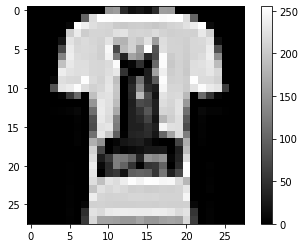

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: t-shirt/top




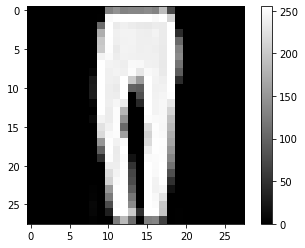

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: trouser




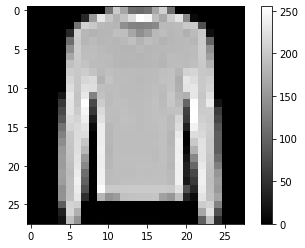

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: pullover




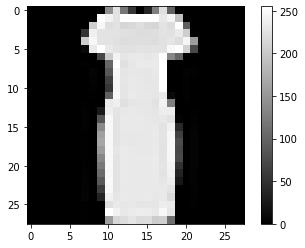

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: dress




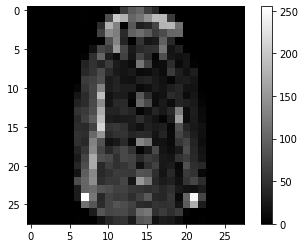

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: coat




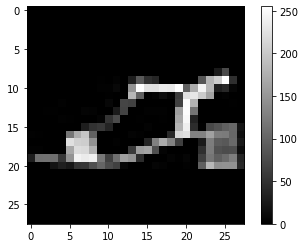

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: sandal




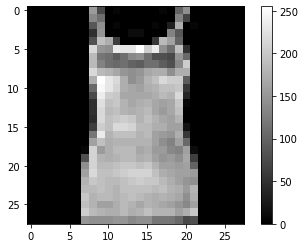

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: shirt




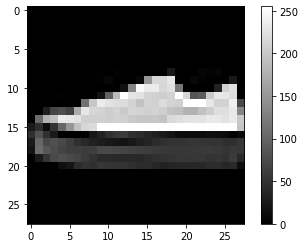

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: sneaker




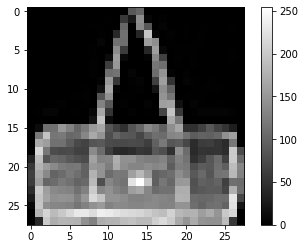

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: bag




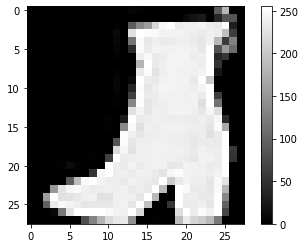

The available labels are: ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
Label the provided item: ankle boot


Completed preprocessing
Budget reduced from "10" to "0"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "1000" to "989"


In [7]:
# Query oracle for labels, 10 of them are input by user 
# and the rest of the 990 are automatically queried from input ground truth
active_test.query_vetted(interactive=True, budget=10, raw=None, visualizer=None)
active_test.query_vetted(interactive=False, 
                         budget=1000, 
                         batch_size=10, 
                         raw=None, visualizer=None)

## Estimate performance

We now get the estimated performance results.

In [8]:
# Run Learned Multiple oracle function on Test data and model predictions
active_test.test()

result = active_test.get_test_results()
print(np.abs(result['tester_metric'] - model_accuracy))

0.016542906662139867


## Evaluate All Query Strategies

To evaluate the query strategies, calculate the above evaluation metric.  The goal is to choose a query strategy that requires the least amount of labeled samples to reach a state of accuracy.  To show this, the estimation error is plotted for each query strategy across a set of different budget values.  The following cell runs the comparison.  Previously computed results are loaded and visualized in a subsequent cell.  If you would like to plot more points, change the `num_budgets`, `budget_counter`, and `trials` variables.

In [9]:
from active_tester.query_strategy.random import Random
from active_tester.query_strategy.noisy_label_uncertainty import LabelUncertainty
from active_tester.query_strategy.classifier_uncertainty import ClassifierUncertainty
from active_tester.query_strategy.dpp import DPP
from active_tester.query_strategy.MCM import MCM
from active_tester.query_strategy.prototypical import Prototypical
import json

# Initialize iterators and result holders
hist_raw_results = [['Query Strategy', 'actual_accuracy - estimated_accuracy', 'budget']]

query_strategies_name = ['Random', 'LabelUncertainty', 'ClassifierUncertainty', 'MCM', 'Prototypical', 'DPP']
query_strategies = [Random(), LabelUncertainty(), ClassifierUncertainty(), 
                    MCM(estimation_method=oracle_multiple_labels), Prototypical(), DPP()]

num_budgets = 1
budget_counter = 100
trials = 2

# Loop through query strategies
for query_num,query_strategy in enumerate(query_strategies):
    
    counter = budget_counter
    cur_budget = 0
    
    # Loop through num samples
    while cur_budget < num_budgets:
        # Loop through trials
        for trial in range(trials):
            # Intialization and ingesting testing data
            # Protoypical case require reinstantiation of Prototypical class
            if query_strategies_name[query_num] == 'Prototypical':
                active_test = ActiveTester(Learned(metric=accuracy_score, 
                                                   use_features=True,
                                                   estimation_method=oracle_multiple_labels),
                                           Prototypical())
            else:
                active_test = ActiveTester(Learned(metric=accuracy_score, 
                                                   use_features=True,
                                                   estimation_method=oracle_multiple_labels),
                                           query_strategy)

            active_test.standardize_data(is_img_byte=True, 
                                         X=X, 
                                         classes=class_names, 
                                         Y_ground_truth=Y_ground_truth,
                                         Y_vetted=None, 
                                         Y_noisy=Y_noisy)

            # Run model
            # Prototypical case requires calculating embeddings
            if query_strategies_name[query_num] == 'Prototypical':
                active_test.gen_model_predictions(model2,[('probabilities',10),('embeddings',32)])
            else:
                active_test.gen_model_predictions(model2)

            # Query vetted with current budget size and test
            active_test.query_vetted(interactive=False, 
                                     budget=counter, 
                                     batch_size=50, 
                                     raw=None, 
                                     visualizer=None)

            active_test.test()
            result = active_test.get_test_results()
            abs_error = np.abs(model_accuracy - result['tester_metric'])
            print("QueryStrat: %s\nBudget:" % (query_strategies_name[query_num]) +
                  " %d\nEvaluation Result: %s" % (counter, 
                                                  abs_error))

            # Add row to final results
            hist_raw_results.append([query_strategies_name[query_num], 
                                        abs_error, 
                                        counter])
            
        # Increment counters to next budget size
        counter += budget_counter
        cur_budget += 1
    
print(hist_raw_results)

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.12775186666214
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "89"
QueryStrat: Random
Budget: 100
Evaluation Result: 0.05684616666213993
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: LabelUncertainty
Budget: 100
Evaluation Result: 0.038805156662139795
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
QueryStrat: LabelUncertainty
Budget: 100
Evaluation Result: 0.08072047666213988
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "89"
QueryStrat: ClassifierUncertainty
Budget: 100
Evaluation Result: 0.09044347666213992
Beginning pr

## Plot results from the cell above

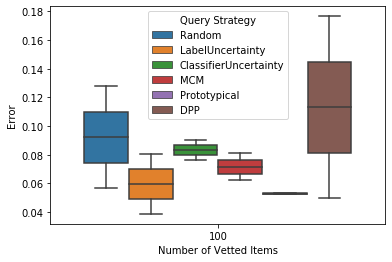

In [10]:
# Convert to pandas, export to csv, and plot
pandas_results = pd.DataFrame(data = hist_raw_results[1:], 
                              columns=['Query Strategy', 'Error', 'Number of Vetted Items'])

pandas_results.to_csv('demo_images_results.csv', index=False)

ax = sns.boxplot(y='Error', x='Number of Vetted Items', hue='Query Strategy', data=pandas_results)

## Precomputed results

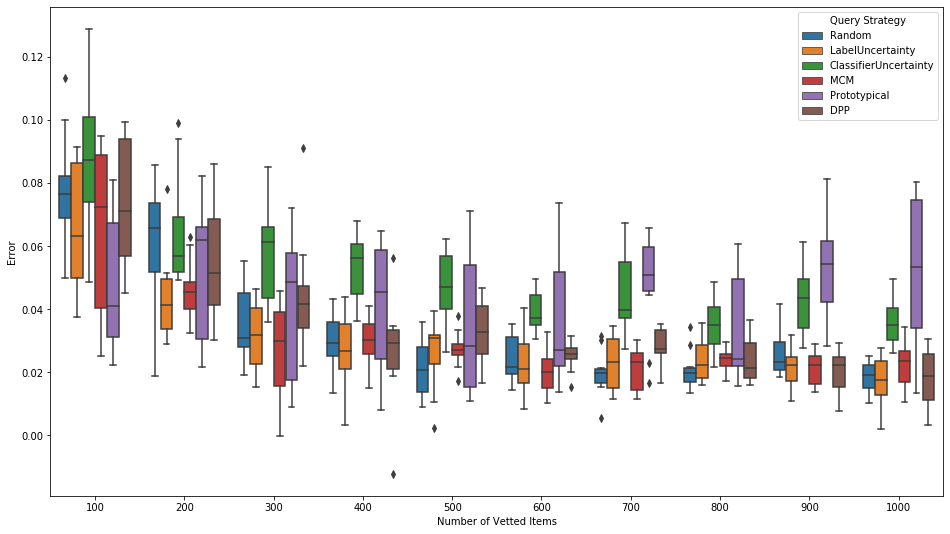

In [11]:
# Load results from csv and plot
complete_results = pd.read_csv("demo_images_results_complete.csv")
complete_results.rename(columns={"actual_accuracy - estimated_accuracy": "Error", "budget": "Number of Vetted Items"},
                        inplace=True)

plt.figure(figsize=(16, 9))
ax = sns.boxplot(y='Error', x='Number of Vetted Items', hue='Query Strategy', data=complete_results)